In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install dask[dataframe]

     |████████████████████████████████| 92kB 4.3MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=e9b0ca2022e8954a39b11b893c64ee5a80b3561a5409fd852ae330b3f7455e93
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [ ]:
!pip install gpxpy

     |████████████████████████████████| 112kB 5.7MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.4.2-cp36-none-any.whl size=42545 sha256=038d9bdd7f4c818f8722140c78968bc3abb24162cb5df07965075b9c8e0b778f
  Stored in directory: /root/.cache/pip/wheels/d9/df/ed/b52985999b3967fa0ef8de22b3dc8ad3494ce3380d5328dd0f
Successfully built gpxpy


In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import xgboost as xgb
import matplotlib
import urllib.request
import zipfile
import random
import itertools
import math
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import time
import folium
from folium import Choropleth ,  Circle, Marker
import gpxpy.geo

warnings.simplefilter('ignore')

In [ ]:
#reading jan 2019 data

data_jan_2019 = dd.read_csv("/content/drive/My Drive/nyc-project/dataset/yellow_tripdata_2019-01.csv")
data_jan_2019.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [ ]:
data_jan_2019.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [ ]:
len(data_jan_2019)

7667792

In [ ]:
print("Number of columns: " +str(len(data_jan_2019.columns)))

Number of columns: 18


In [ ]:
data_jan_2019.isnull().sum().compute()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4855978
dtype: int64

In [ ]:
data_jan_2019 = data_jan_2019.drop(columns=['congestion_surcharge'])
data_jan_2019.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55


In [ ]:
#adding Trip Duration Column

def timeToUnix(t):
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    t_tuple = change.timetuple() 
    return time.mktime(t_tuple) + 3600

def prepare_dataframe(df):
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    dataFrame = df[['tpep_pickup_datetime','trip_distance','PULocationID','DOLocationID','total_amount']].compute()
    dataFrame["trip_duration"] = trip_duration
    dataFrame["pickup_time"] = pickup_time
    dataFrame["speed"] = (dataFrame["trip_distance"]/dataFrame["trip_duration"])*60  #speed in miles/hr
    
    return dataFrame

In [ ]:
start = time.time()
df_jan_2019 = prepare_dataframe(data_jan_2019)

print(time.time()- start)

217.6149332523346


In [ ]:
df_jan_2019.head()

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,total_amount,trip_duration,pickup_time,speed
0,2019-01-01 00:46:40,1.5,151,239,9.95,6.666667,1.546307e+09,13.500
1,2019-01-01 00:59:47,2.6,239,246,16.30,19.200000,1.546308e+09,8.125
2,2018-12-21 13:48:30,0.0,236,236,5.80,4.166667,1.545404e+09,0.000
3,2018-11-28 15:52:25,0.0,193,193,7.55,3.333333,1.543424e+09,0.000
4,2018-11-28 15:56:57,0.0,193,193,55.55,1.600000,1.543424e+09,0.000


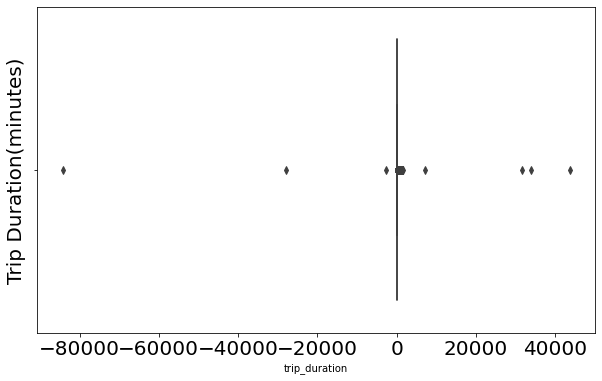

In [ ]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = df_jan_2019, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

In [ ]:
#deleting courses with trip duration > 12h & trip duration < 0h
df1_jan_2019 = df_jan_2019[(df_jan_2019.trip_duration>1) & (df_jan_2019.trip_duration<720)]
df1_jan_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7572771 entries, 0 to 521249
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   tpep_pickup_datetime  object 
 1   trip_distance         float64
 2   PULocationID          int64  
 3   DOLocationID          int64  
 4   total_amount          float64
 5   trip_duration         float64
 6   pickup_time           float64
 7   speed                 float64
dtypes: float64(5), int64(2), object(1)
memory usage: 520.0+ MB


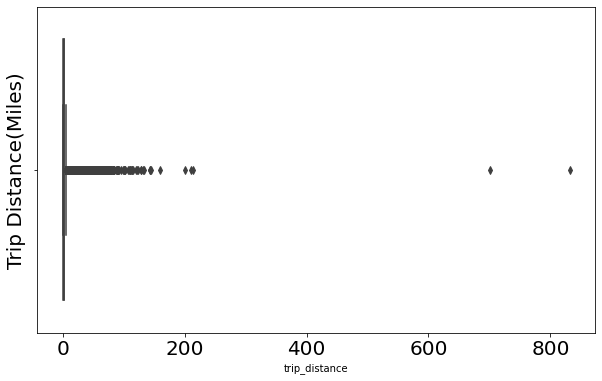

In [ ]:
#trip distance
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = df1_jan_2019, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

In [ ]:
# We investigate Quartiles
quantile_tripDistance = df1_jan_2019.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.0miles
10th percentile value of trip distance is 0.6miles
20th percentile value of trip distance is 0.82miles
30th percentile value of trip distance is 1.03miles
40th percentile value of trip distance is 1.28miles
50th percentile value of trip distance is 1.55miles
60th percentile value of trip distance is 1.9miles
70th percentile value of trip distance is 2.43miles
80th percentile value of trip distance is 3.4miles
90th percentile value of trip distance is 6.43miles
100th percentile value of trip distance is 831.8miles


In [ ]:
quantile_tripDistance = df1_jan_2019.trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))



99.1 percentile value of trip distance is 19.15miles
99.2 percentile value of trip distance is 19.4miles
99.3 percentile value of trip distance is 19.71miles
99.4 percentile value of trip distance is 20.1miles
99.5 percentile value of trip distance is 20.5miles
99.6 percentile value of trip distance is 21.0miles
99.7 percentile value of trip distance is 21.6miles
99.8 percentile value of trip distance is 22.7miles
99.9 percentile value of trip distance is 26.29miles
100.0 percentile value of trip distance is 831.8miles


In [ ]:
#Removing courses with erounous speed
df1_jan_2019 = df1_jan_2019[(df1_jan_2019.trip_distance>0) & (df1_jan_2019.trip_distance<27)]
df1_jan_2019.shape


(7554959, 8)

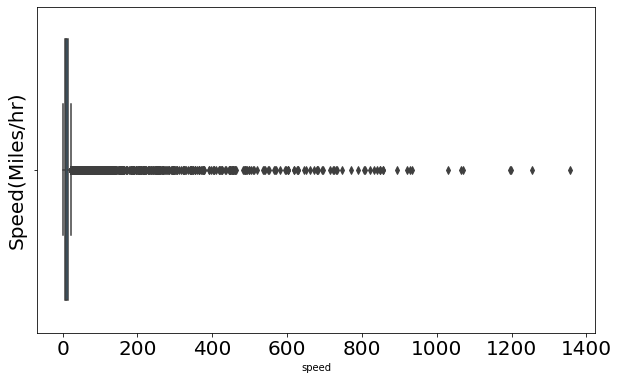

In [ ]:
#speed
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = df1_jan_2019, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

In [ ]:
quantile_speed = df1_jan_2019.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {} miles/hr".format(int(i*100), quantile_speed[i]))

0th percentile value of speed is 0.001694995056264419 miles/hr
10th percentile value of speed is 5.860465116279069 miles/hr
20th percentile value of speed is 7.12871287128713 miles/hr
30th percentile value of speed is 8.145985401459853 miles/hr
40th percentile value of speed is 9.111294311624073 miles/hr
50th percentile value of speed is 10.120879120879122 miles/hr
60th percentile value of speed is 11.283582089552237 miles/hr
70th percentile value of speed is 12.76595744680851 miles/hr
80th percentile value of speed is 15.0 miles/hr
90th percentile value of speed is 19.509677419354837 miles/hr
100th percentile value of speed is 1355.625 miles/hr


In [ ]:

qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = df1_jan_2019.speed.quantile(qValues)
for i in qValues:
    print("{} percentile value of speed is {} miles/hr".format((i*100), quantile_speed[i]))

99.1 percentile value of speed is 35.840505204286984 miles/hr
99.2 percentile value of speed is 36.46077871652756 miles/hr
99.3 percentile value of speed is 37.12943544176368 miles/hr
99.4 percentile value of speed is 37.87110187110187 miles/hr
99.5 percentile value of speed is 38.704830053667266 miles/hr
99.6 percentile value of speed is 39.685884691848905 miles/hr
99.7 percentile value of speed is 40.835463794257095 miles/hr
99.8 percentile value of speed is 42.39138862876233 miles/hr
99.9 percentile value of speed is 44.7503116672897 miles/hr
100.0 percentile value of speed is 1355.625 miles/hr


In [ ]:
#Deleting courses with erounous speed
df1_jan_2019 = df1_jan_2019[(df1_jan_2019.speed>0) & (df1_jan_2019.speed<45)]

In [ ]:
df1_jan_2019.shape

(7547954, 8)

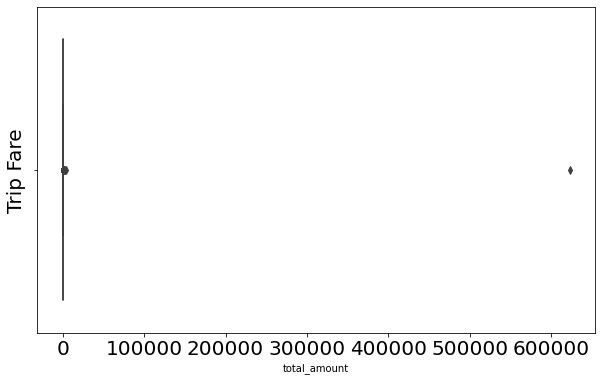

In [ ]:
# total amount
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = df1_jan_2019, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

In [ ]:
quantile_totalAmount = df1_jan_2019.total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))


99.1 percentile value of trip fare is 70.27
99.2 percentile value of trip fare is 70.27
99.3 percentile value of trip fare is 70.27
99.4 percentile value of trip fare is 73.06
99.5 percentile value of trip fare is 73.2
99.6 percentile value of trip fare is 75.67
99.7 percentile value of trip fare is 76.13
99.8 percentile value of trip fare is 81.51
99.9 percentile value of trip fare is 94.60047000001184
100.0 percentile value of trip fare is 623261.66


In [ ]:
df1_jan_2019 = df1_jan_2019[(df1_jan_2019.total_amount>0) & (df1_jan_2019.total_amount<95)]
df1_jan_2019.shape

(7536057, 8)

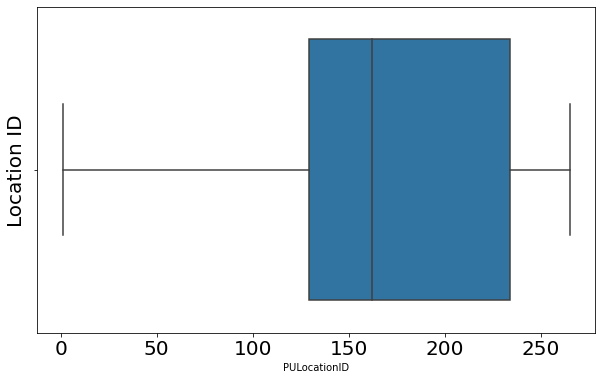

In [ ]:
# location ID
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("PULocationID", data = df1_jan_2019, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Location ID", fontsize = 20)
plt.show()

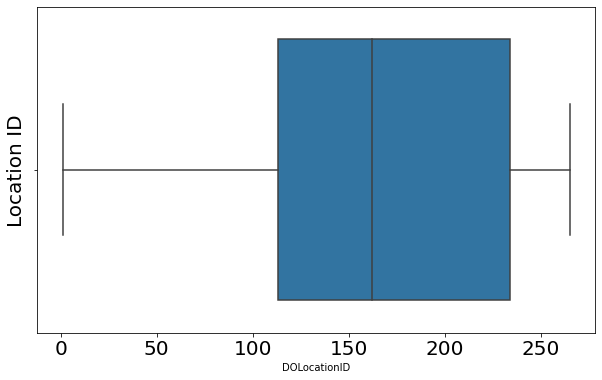

In [ ]:
# location ID
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("DOLocationID", data = df1_jan_2019, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Location ID", fontsize = 20)
plt.show()

In [ ]:
#Clustering pickups
coord = df1_jan_2019[["PULocationID"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)

In [ ]:
cluster_column = regions.predict(df1_jan_2019[["PULocationID"]])
df1_jan_2019["pickup_cluster"] = cluster_column
df1_jan_2019.head()

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,total_amount,trip_duration,pickup_time,speed,pickup_cluster
0,2019-01-01 00:46:40,1.5,151,239,9.95,6.666667,1.546307e+09,13.500000,16
1,2019-01-01 00:59:47,2.6,239,246,16.30,19.200000,1.546308e+09,8.125000,17
7,2019-01-01 00:21:28,1.3,163,229,9.05,7.150000,1.546306e+09,10.909091,2
8,2019-01-01 00:32:01,3.7,229,7,18.50,13.633333,1.546306e+09,16.283619,21
9,2019-01-01 00:57:32,2.1,141,234,13.00,12.000000,1.546308e+09,10.500000,4


In [ ]:
df1_jan_2019["pickup_cluster"].unique()

array([16, 17,  2, 21,  4,  9, 18, 20, 22, 11, 29, 25, 19,  6, 15, 13, 14,
       10, 27,  5,  1,  3, 28,  7, 24,  8, 12,  0, 26, 23], dtype=int32)

In [ ]:
#Grouping the mounthly data by region
df1_jan_2019.rename(columns={'tpep_pickup_datetime':'time','trip_distance':'demand',},inplace=True)
df1_jan_2019['time'] = pd.to_datetime(df1_jan_2019['time'])
grouped_df_jan_2019 = df1_jan_2019[["pickup_cluster", "time", "demand"]].groupby(by = ["pickup_cluster", "time"]).count()

In [ ]:
grouped_df_jan_2019.head()

demand
pickup_cluster time                       
0              2009-01-01 00:21:52       1
               2018-12-31 16:48:55       1
               2018-12-31 17:22:10       1
               2018-12-31 18:45:10       1
               2018-12-31 20:04:48       1

In [ ]:
#Cluster example
cluster = grouped_df_jan_2019.loc[0]
#Resampling Data in region j into one hour step
cluster = cluster.resample('1h').sum() 
#Feature Engineering
cluster['Date time'] = cluster.index
cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
cluster['hour']=cluster['Date time'].dt.hour 
cluster['day']=cluster['Date time'].dt.day
cluster['dayofweek']=cluster['Date time'].dt.dayofweek  

In [ ]:
cluster.head()

,demand,Date time,hour,day,dayofweek
time,,,,,
2009-01-01 00:00:00,1,2009-01-01 00:00:00,0,1,3
2009-01-01 01:00:00,0,2009-01-01 01:00:00,1,1,3
2009-01-01 02:00:00,0,2009-01-01 02:00:00,2,1,3
2009-01-01 03:00:00,0,2009-01-01 03:00:00,3,1,3
2009-01-01 04:00:00,0,2009-01-01 04:00:00,4,1,3
